In [1]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

# Download Dataset

In [2]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
IMAGE_CHANNEL_NUM = 3
IMAGE_SIZE = 32
CLASS_NUM = 10
BATCH_NUM = 256
NOISE_DIM = 100

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
    
    
class UnFlatten(nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, 3, 32, 32)
        return x

    
class GAN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
            Flatten(),
            nn.Linear(in_features=32*32*3, out_features=8000),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(in_features=8000, out_features=8000),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(in_features=8000, out_features=3072),
            nn.Dropout(0.4),
            nn.Sigmoid(),
        )
        
        self.generator = nn.Sequential(
            Flatten(),
            nn.Linear(in_features=100, out_features=1600),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1600, out_features=1600),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1600, out_features=32*32*3),
            nn.Tanh(),
            UnFlatten(),
        )

    def training_step(self, batch, batch_idx, optimizer_idx):
        inputs, targets = batch
        device = inputs.device
        noise = torch.randn((inputs.shape[0], NOISE_DIM, 1, 1)).to(device)
        inputs_gen = self.generator(noise)
        
        if optimizer_idx == 0:
            output = self.discriminator(inputs)
            output_gen = self.discriminator(inputs_gen)
            loss_d = F.binary_cross_entropy(output, torch.ones_like(output).to(device))
            loss_g = F.binary_cross_entropy(output_gen, torch.zeros_like(output_gen).to(device))

            loss = (loss_d + loss_g) / 2
            
            self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        else:
            output_gen = self.discriminator(inputs_gen)
            loss_g = F.binary_cross_entropy(output_gen, torch.ones_like(output_gen).float().to(device))
            
            loss = loss_g
            self.log("train_loss_g", loss, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def training_epoch_end(self, outputs):
        if self.current_epoch % 30 == 0:
            noise = torch.randn((10, NOISE_DIM, 1, 1)).to(self.device)
            output_gen = self.generator(noise)
            imgs = vutils.make_grid(output_gen.detach().cpu(), padding=2, normalize=True)
            fig = plt.figure(figsize=(16,16))
            plt.axis("off")
            plt.imshow(np.transpose(imgs,(1,2,0)))
            plt.show()
    
    def train_dataloader(self):
        transform_train = transforms.Compose([
            transforms.ToTensor(),
#             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
        return DataLoader(train_set, batch_size=BATCH_NUM, shuffle=True, num_workers=2)

    def configure_optimizers(self):
        optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        optimizer_g = torch.optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

        return optimizer_d, optimizer_g

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | discriminator | Sequential | 113 M 
1 | generator     | Sequential | 7.6 M 
---------------------------------------------
120 M     Trainable params
0         Non-trainable params
120 M     Total params


Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


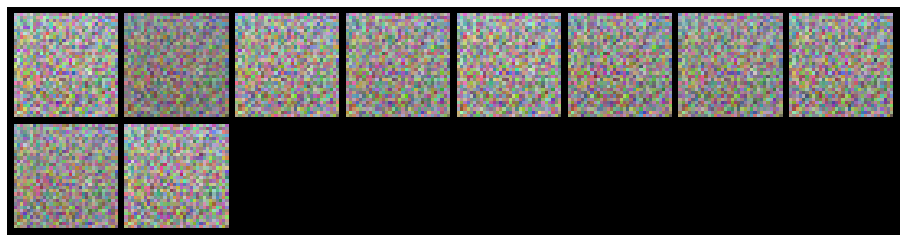

In [ ]:
gan = GAN()
trainer = pl.Trainer(gpus=1, max_epochs=300)
trainer.fit(gan)